In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### mnist

In [3]:
(x_train,y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

# 11.1 Gradient Vanishing, exploding

## 11.1.1 initializer

In [5]:
#글로럿 == Xavier : 분산 : 1/fan(avg)
keras.layers.Dense(10,activation='tanh',kernel_initializer = keras.initializers.glorot_uniform)
#he : 분산 : 2/fan(in) 
keras.layers.Dense(10,activation='relu',kernel_initializer = keras.initializers.he_normal)
#lecun : 분산 : 1/fan(in)
keras.layers.Dense(10,activation='selu',kernel_initializer = keras.initializers.he_normal)


### Variance Scaling

In [6]:
#Varaiance Scaling
#he normal의 분산을 2/fan_avg 로 바꾸기
he_avg_init = keras.initializers.variance_scaling(scale=2, mode = 'fan_avg',
                                                 distribution = 'normal')

## 11.1.2 activation function

In [7]:
z = np.linspace(-5,5,50)

In [8]:
def relu(z):
    return np.maximum(0,z)

### relu

(-5.0, 5.0, -1.0, 5.0)

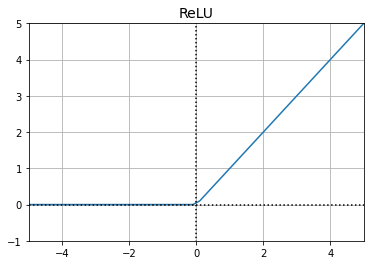

In [9]:
plt.plot(z,relu(z))
plt.plot([-5,5],[0,0],'k:')
plt.plot([0,0],[-5,5],'k:')
plt.grid(True)
plt.title("ReLU", fontsize=14)
plt.axis([-5,5,-1,5])

### leayky relu

In [10]:
keras.layers.LeakyReLU(alpha = 0.1)

In [11]:
def leaky_relu(z,alpha):
    return np.maximum(alpha*z,z)

(-5.0, 5.0, -1.0, 5.0)

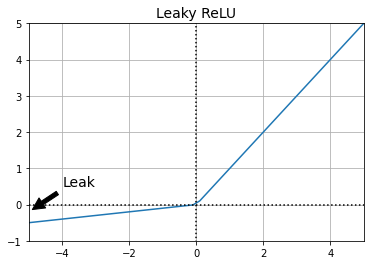

In [12]:
plt.plot(z,leaky_relu(z,0.1))
plt.plot([-5,5],[0,0],'k:')
plt.plot([0,0],[-5,5],'k:')
plt.grid(True)
props= dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5,0.5),xy=(-5,-0.2),arrowprops=props,fontsize=14, ha="center")
plt.title("Leaky ReLU", fontsize=14)
plt.axis([-5,5,-1,5])

### elu

In [13]:
def elu(z,alpha):
    exponential =alpha*(np.exp(z)-1)
    return np.where(z<=0,exponential,z)

(-5.0, 5.0, -1.0, 5.0)

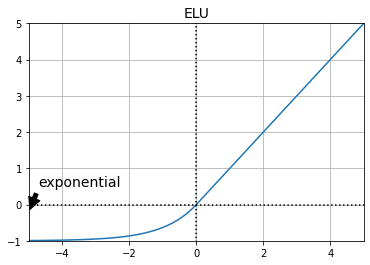

In [14]:
plt.plot(z,elu(z,1))
plt.plot([-5,5],[0,0],'k:')
plt.plot([0,0],[-5,5],'k:')
plt.grid(True)
props= dict(facecolor='black', shrink=0.1)
plt.annotate('exponential', xytext=(-3.5,0.5),xy=(-5,-0.2),arrowprops=props,fontsize=14, ha="center")
plt.title("ELU", fontsize=14)
plt.axis([-5,5,-1,5])

### selu

In [15]:
#스케일이 조정된 elu 활성화 함수
#자기 정규화 경향.
#lecun normal과 함께 써야함.
keras.layers.Dense(1,keras.initializers.lecun_normal,keras.activations.selu)

## 11.1.3 배치 정규화

훈련시 :활성화 함수를 통과하기 전이나 후 , 배치 입력을 정규화  
테스트 시 : 훈련 중 이동평균으로 추정한 평균과 표준편차를 이용해 샘플을 추론 

#### 활성화함수 이후에 추가 : 활성화 함수를 파라미터로 추가

In [16]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape =[28,28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300,activation ='selu', kernel_initializer = 'lecun_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100,activation ='selu', kernel_initializer = 'lecun_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10,activation = "softmax")
]
)

#### 활성화 함수 이전에 추가 : 활성화 함수를 별도의 레이어로 추가

In [17]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape =[28,28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, kernel_initializer = 'lecun_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("selu"),
        keras.layers.Dense(100, kernel_initializer = 'lecun_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("selu"),
        keras.layers.Dense(10,activation = "softmax")
]
)

#### batchnorm의 파라미터

In [18]:
model.summary()
#batch norm은 4개의 파라미터 존재. 4 x 784 = 3136

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [19]:
[(var.name, var.trainable) for var in model.layers[1].variables]
#두개는 하이퍼파리미터, 두개는 학습가능한 이동평균 평균, 표준편차

[('batch_normalization_3/gamma:0', True),
 ('batch_normalization_3/beta:0', True),
 ('batch_normalization_3/moving_mean:0', False),
 ('batch_normalization_3/moving_variance:0', False)]

In [20]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy,
              metrics = ["accuracy"],
             optimizer = 'adam')

In [21]:
x_train.shape

(60000, 28, 28)

In [22]:
y_train.shape

(60000,)

In [23]:
model.fit(x_train,y_train, epochs = 5,batch_size=32
         )

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4119 - accuracy: 0.8753
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1886 - accuracy: 0.9431
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1312 - accuracy: 0.9591
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1005 - accuracy: 0.9685
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0805 - accuracy: 0.9735


In [24]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 0s 435us/step - loss: 0.4722 - accuracy: 0.9648


[0.47217968106269836, 0.9648000001907349]

## 11.1.4 그레디언트 클리핑

In [25]:
optimizer = keras.optimizers.SGD(clipvalue  = 1.0) 
#-1 ~ 1 사이로 그레디언트를 클리핑함

In [26]:
optimizer = keras.optimizers.SGD(clipnorm = 1.0) 
#~1 ~ 1 사이로 그레디언트를 정규화

# 11.2 사전훈련 층 재사용

#### 전이학습.

비슷한 task 일수록 많은 층을 재사용.  
아주 비슷하면 출력층만 교체해도 됨

## 11.2.1 케라스를 사용한 전이 학습

#### 원 모델 : 1~10 분류

#### 전이학습 모델 : 5,not 5 이진 분류

In [27]:
model.save("mnist_softmax_10.h5")

In [28]:
model_A = keras.models.load_model("mnist_softmax_10.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1,activation = "sigmoid"))

In [29]:
y_5_or_not = (y_train==5)

#### 레이어를 가져온 모델도 함께 훈련되기 때문에 복사본을 확보

In [30]:
model_A_clone = keras.models.clone_model(model)
model_A_clone.set_weights(model.get_weights())

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [32]:
for l in model_B_on_A.layers:
    print(l.trainable)

False
False
False
False
False
False
False
False
True


In [33]:
model_B_on_A.compile(loss= keras.losses.binary_crossentropy,
                    optimizer = "sgd",
                    metrics = ["accuracy",keras.metrics.Precision()])

In [34]:
history = model_B_on_A.fit(x_train,y_5_or_not,epochs=10,validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 1s 794us/step - loss: 0.3702 - accuracy: 0.8626 - precision: 0.4462 - val_loss: 0.1110 - val_accuracy: 0.9852 - val_precision: 0.9331
Epoch 2/10
1500/1500 [==============================] - 1s 576us/step - loss: 0.1074 - accuracy: 0.9844 - precision: 0.9172 - val_loss: 0.0770 - val_accuracy: 0.9888 - val_precision: 0.9521
Epoch 3/10
1500/1500 [==============================] - 1s 564us/step - loss: 0.0768 - accuracy: 0.9863 - precision: 0.9373 - val_loss: 0.0663 - val_accuracy: 0.9884 - val_precision: 0.9571
Epoch 4/10
1500/1500 [==============================] - 1s 578us/step - loss: 0.0708 - accuracy: 0.9875 - precision: 0.9487 - val_loss: 0.0567 - val_accuracy: 0.9895 - val_precision: 0.9559
Epoch 5/10
1500/1500 [==============================] - 1s 609us/step - loss: 0.0584 - accuracy: 0.9883 - precision: 0.9479 - val_loss: 0.0535 - val_accuracy: 0.9897 - val_precision: 0.9551
Epoch 6/10
1500/1500 [============================

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

<AxesSubplot:>

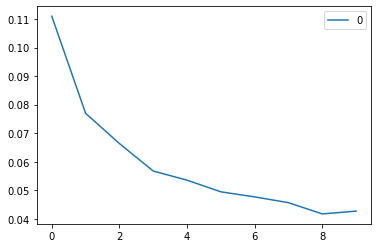

In [36]:
pd.DataFrame(history.history['val_loss']).plot()

In [37]:
model_B_on_A.evaluate(x_test, (y_test==5))

313/313 [==============================] - 0s 578us/step - loss: 0.0538 - accuracy: 0.9889 - precision: 0.9525


[0.053844764828681946, 0.9889000058174133, 0.952491283416748]

In [38]:
predict = model_B_on_A.predict_classes(x_test[:10])

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
predict = predict.flatten()
cnt = 0
for index in range(len(predict)):
    if predict[index] == (y_test==5)[index]:
            cnt += 1
print(predict)
print(y_test==5)
print(cnt/len(predict)* 100, "%")

[0 0 0 0 0 0 0 0 1 0]
[False False False ... False  True False]
100.0 %


In [40]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [41]:
for l in model_B_on_A.layers:
    print(l.trainable)

True
True
True
True
True
True
True
True
True


In [42]:
model_B_on_A.compile(loss = keras.losses.binary_crossentropy,
                    optimizer = 'adam',
                    metrics = ['accuracy',keras.metrics.Precision()])

In [43]:
history = model_B_on_A.fit(x_train,y_5_or_not,epochs=10,
                          validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 3s 1ms/step - loss: 0.0297 - accuracy: 0.9908 - precision_1: 0.9561 - val_loss: 0.0637 - val_accuracy: 0.9911 - val_precision_1: 0.9451
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0200 - accuracy: 0.9934 - precision_1: 0.9711 - val_loss: 0.0533 - val_accuracy: 0.9914 - val_precision_1: 0.9502
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0141 - accuracy: 0.9947 - precision_1: 0.9752 - val_loss: 0.1046 - val_accuracy: 0.9904 - val_precision_1: 0.9376
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0111 - accuracy: 0.9963 - precision_1: 0.9849 - val_loss: 0.0998 - val_accuracy: 0.9912 - val_precision_1: 0.9397
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.0094 - accuracy: 0.9968 - precision_1: 0.9842 - val_loss: 0.0742 - val_accuracy: 0.9890 - val_precision_1: 0.9142
Epoch 6/10
1500/1500 [==================

<AxesSubplot:>

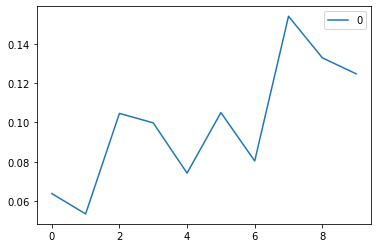

In [44]:
pd.DataFrame(history.history['val_loss']).plot()
#다 열어서 하니깐 오버피팅

In [45]:
predict = model_B_on_A.predict_classes(x_test[:10])

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [46]:
predict = predict.flatten()
cnt = 0
for index in range(len(predict)):
    if predict[index] == (y_test==5)[index]:
            cnt += 1
print(predict)
print(y_test==5)
print(cnt/len(predict)* 100, "%")

[0 0 0 0 0 0 0 0 1 0]
[False False False ... False  True False]
100.0 %


In [47]:
model_B_on_A.evaluate(x_test, (y_test==5))
#전이학습은 모든 경우에서 좋지는 않음.

313/313 [==============================] - 0s 581us/step - loss: 0.0608 - accuracy: 0.9926 - precision_1: 0.9504


[0.06075865402817726, 0.9926000237464905, 0.950440526008606]

# 11.3 고속 옵티마이저

## 11.3.1 모멘텀 최적화

In [48]:
#그레디언트를 속도가 아닌 가속도로 이용
optimzer = keras.optimizers.SGD(lr = 0.001, momentum = 0.9)

## 11.3.2 네스테로프 모멘텀 최적화

In [49]:
#모멘텀 방향으로 조금 앞선 위치에서 그레디언트 계산
optimizer = keras.optimizers.SGD(lr = 0.001, momentum= 0.9, nesterov=True)

## 11.3.3 AdaGrad

In [50]:
#진행 방향으로 편미분 제곱값을 누적하여 스케일 구함.
#업데이트 시 스케일로 나누어줌. --> 편미분값 클수록(스케일 클수록) 더 규제받음
#너무 빨리 멈추는 경향이 있어 심층신경망 보다는 간단한 모델에 사용하는 것을 추천
optimizer = keras.optimizers.Adagrad()

## 11.3.4 RMSProp

In [51]:
#너무 빨리 느려지는 AdaGrad의 단점을 극복
#최근 n개의 그레디언트만 누적하여 나누어줌
optimizer = keras.optimizers.RMSprop(rho=0.9)

## 11.3.5 Adam, Nadam

In [52]:
#Adam = Momentom + RMSprop
optimizer = keras.optimizers.Adam(lr = 0.001, beta_1=0.9,beta_2=0.999)

In [53]:
#Adam + nestrov
optimizer = keras.optimizers.Nadam(lr = 0.001, beta_1=0.9,beta_2=0.999)

## 11.3.6 학습률 스케줄링

#### 거듭제곱 기반

In [54]:
#lr = lr / (1+t/s)^c
#c는 일반적으로 1.
#t= s일때 1/2만큼 줄어듦.
optimizer = keras.optimizers.SGD(lr=0.01, decay = 1e-4) 
#decay = 1/s

#### 지수 기반

In [55]:
def exponential_decay(epoch):
    return 0.01 * 0.1**(epoch/20) 
#20에폭마다 0.1 씩 감소.

In [56]:
#콜백으로 케라스 모델에 추가.
exponential_decay_callback = keras.callbacks.LearningRateScheduler(exponential_decay)
# 에폭단위가 일반적이고 지수기반이 일반적이니깐 이방법을 사용하는게 좋아보임.

# 11.4 규제를 사용해 과대적합 피하기

## 11.4.1 L1, L2 규제

#### l1

In [57]:
layer  = keras.layers.Dense(1, activation = "selu",
                           kernel_initializer = "lecun_normal",
                           kernel_regularizer = keras.regularizers.l1(0.01))

#### l2

In [58]:
layer  = keras.layers.Dense(1, activation = "selu",
                           kernel_initializer = "lecun_normal",
                           kernel_regularizer = keras.regularizers.l2(0.01))

## 11.4.2 드롭아웃

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape  = [28,28]),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300,activation = 'relu'),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100,activation = 'relu'),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = 'softmax')
   
])

In [7]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
             optimizer = keras.optimizers.Adam(0.001),
             metrics = ['accuracy'])

In [8]:
history = model.fit(x_train,y_train, validation_split=0.2,epochs = 10,batch_size= 64)

Epoch 1/10
750/750 [==============================] - 1s 910us/step - loss: 33.5371 - accuracy: 0.7043 - val_loss: 3.8966 - val_accuracy: 0.9399
Epoch 2/10
750/750 [==============================] - 1s 796us/step - loss: 7.7483 - accuracy: 0.8830 - val_loss: 1.1110 - val_accuracy: 0.9542
Epoch 3/10
750/750 [==============================] - 1s 786us/step - loss: 2.5794 - accuracy: 0.8912 - val_loss: 0.7665 - val_accuracy: 0.9487
Epoch 4/10
750/750 [==============================] - 1s 783us/step - loss: 1.2848 - accuracy: 0.8970 - val_loss: 0.4379 - val_accuracy: 0.9530
Epoch 5/10
750/750 [==============================] - 1s 779us/step - loss: 0.9044 - accuracy: 0.8959 - val_loss: 0.4428 - val_accuracy: 0.9498
Epoch 6/10
750/750 [==============================] - 1s 780us/step - loss: 0.9451 - accuracy: 0.8979 - val_loss: 0.4335 - val_accuracy: 0.9498
Epoch 7/10
750/750 [==============================] - 1s 800us/step - loss: 0.7526 - accuracy: 0.9060 - val_loss: 0.3785 - val_accuracy

<AxesSubplot:>

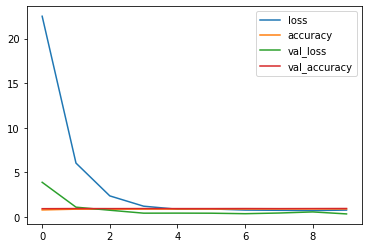

In [9]:
pd.DataFrame(history.history).plot()

In [10]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 0s 315us/step - loss: 0.3844 - accuracy: 0.9604


[0.3844057023525238, 0.9603999853134155]

## 11.4.3 몬테 카를로 드롭아웃

일반 드롭아웃 : 훈련시에만 드롭아웃 적용. 예측은 하나의 모델로,  
MC 드롭아웃  : 예측시에도 드롭아웃을 활용하여 n 번예측, 에측에 대한 확률값 얻을수있음.  
training = True 로 하여 적용가능


In [11]:
y_probas = np.stack([model(x_test, training = True)
                    for sample in range(100)])

y_proba = y_probas.mean(axis = 0)

In [12]:
y_proba.shape

(10000, 10)

#### 첫번째 테스트 샘플의 평균예측

In [25]:
np.round(y_proba[0],2)

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

#### 분산 : 불확실성

In [24]:
y_std = y_probas.std(axis=0)
y_std

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        7.1054274e-15, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

## 11.4.4 max-norm 규제 

가중치 w 의 노름 <=r 이 되도록 제한

In [26]:
keras.layers.Dense(100, activation ='elu', kernel_initializer = 'he_normal',
                  kernel_constraint = keras.constraints.max_norm(1.))